# AML scAtlas

## Single-Cell RNA-Seq Pre-Processing with Scanpy

This example shows the standard pipeline used for processing 10X Genomics single-cell RNA-seq data. Where input data was provided in another format, the initial steps were adapted to create an AnnData object from the provided data format (e.g. count matrix). All QC steps were the same for all samples, and filtering was standardised unless pre-filtered data was supplied.

### Environment Setup

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import scrublet as scr

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

if not os.path.exists("outs"):
    os.makedirs("outs")
if not os.path.exists("plots"):
    os.makedirs("plots")

results_file = 'outs/AML721214_all_filtered.h5ad'
cells_file = 'outs/AML721214_cell_filtered.h5ad'

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


### Prepare AnnData from Cellranger Counts

In [2]:
adata = sc.read_10x_mtx(
    "./cellranger", 
    prefix="721214.",
    var_names='gene_symbols',
    cache=True)

adata.var_names_make_unique()

... reading from cache file cache/cellranger-721214.matrix.h5ad


In [3]:
adata

AnnData object with n_obs × n_vars = 20474 × 33694
    var: 'gene_ids'

### Annotate Data

Metadata was curated to retain as much information from the original report in the first instance, this can always be filtered to the most relevant columns later on. Samples were assigned a 'mutational subgroup' based on the clinical information given and recent ELN AML classification guidelines, to allow sub-classfication of different groups later on.

In [4]:
# Add sample ID metadata
adata.obs["sample"] = "AML721214"
adata.obs["donor"] = "AML721214"

In [5]:
# Add additional metadata
adata.obs["study"] = "petti_2019"
adata.obs["clinical_subgroup"] = "M1"
adata.obs["gender"] = "F"
adata.obs["age"] = "41"
adata.obs["translocations"] = "unknown"
adata.obs["cytogenetics"] = "unknown"
adata.obs["mutations"] = "FLT3-ITD,NPM1"
adata.obs["mutational_subgroup"] = "NPM1"

### Doublet Removal with Scrublet
Performed on raw counts. 

In [6]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.06) #parameter obtained from chromium user guide
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 20.1 seconds


(<Figure size 640x240 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

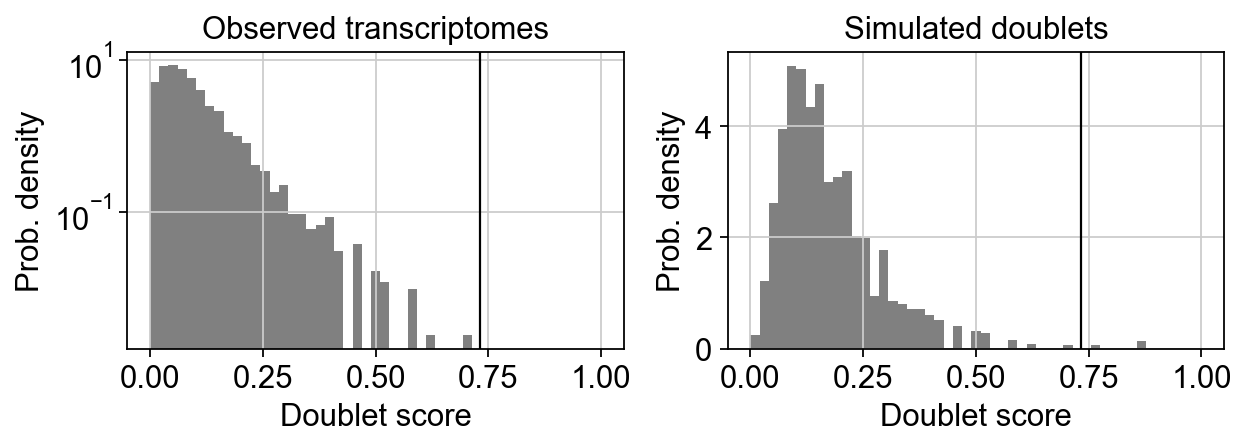

In [7]:
scrub.plot_histogram()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(<Figure size 640x320 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

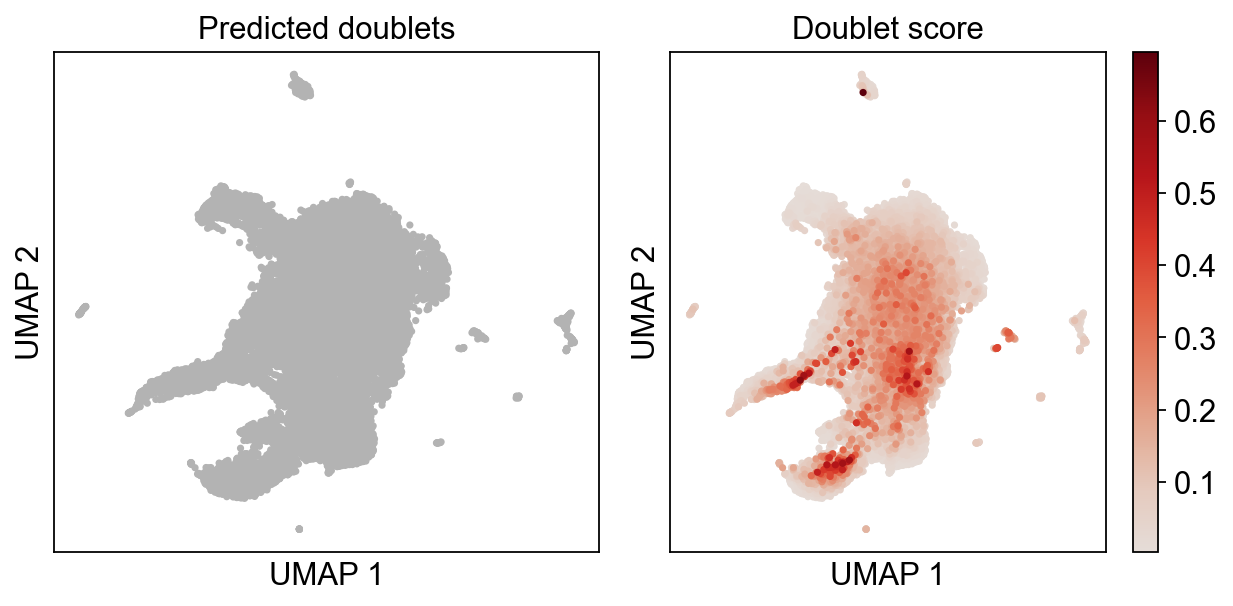

In [8]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

Detected doublet rate = 1.2%
Estimated detectable doublet fraction = 13.4%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.2%


(<Figure size 640x240 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

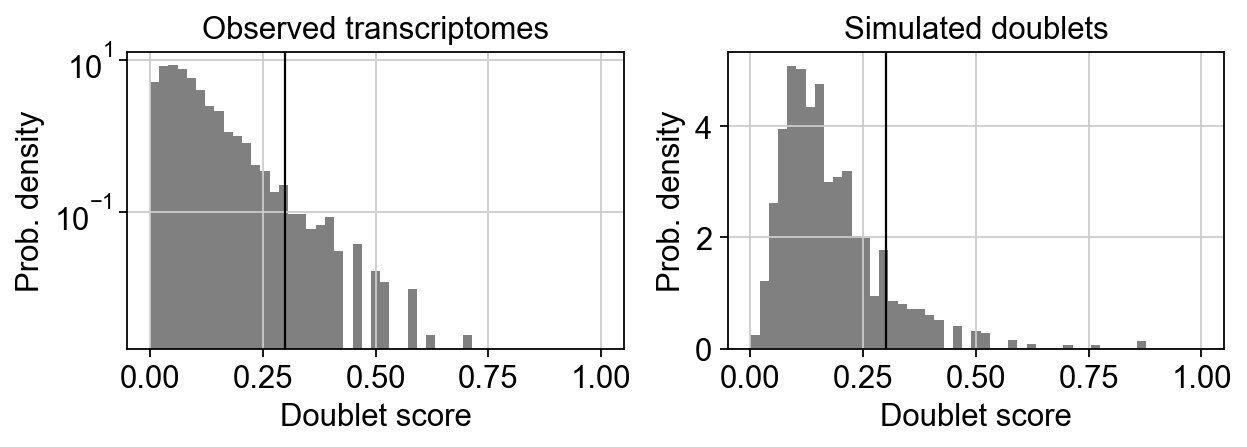

In [9]:
# If 'sensible' threshold has not been automatically set, we can alter this based on the histogram
scrub.call_doublets(threshold=0.3)
scrub.plot_histogram()

(<Figure size 640x320 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

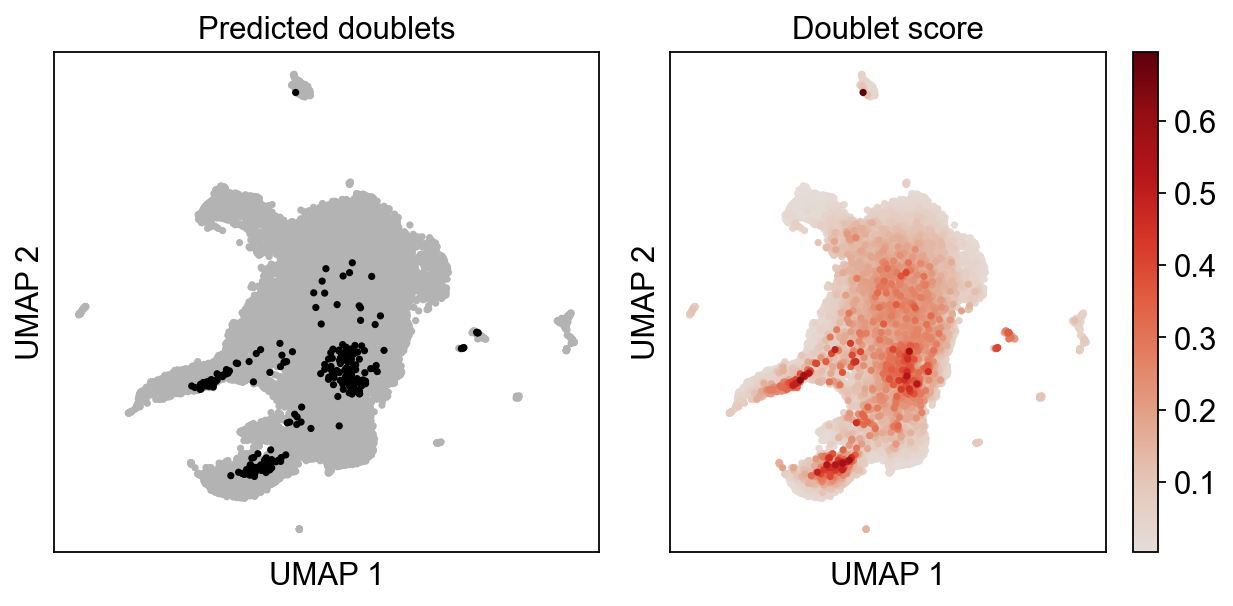

In [10]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

In [11]:
# Add results to AnnData
adata.obs["doublet_score"] = scrub.doublet_scores_obs_
adata.obs["predicted_doublets"] = scrub.predicted_doublets_
sum(adata.obs['predicted_doublets'])

adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

In [12]:
# Remove doublets
print("Initial cells %d"%adata.n_obs)

adata = adata[adata.obs['doublet_info'] == 'False',:]
print("Remaining cells -doublets %d"%adata.n_obs)

Initial cells 20474
Remaining cells -doublets 20221


### Initial QC

In [13]:
# Calculate QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

# Add the total counts per cell
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3760214032.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')


#### Plotting QC

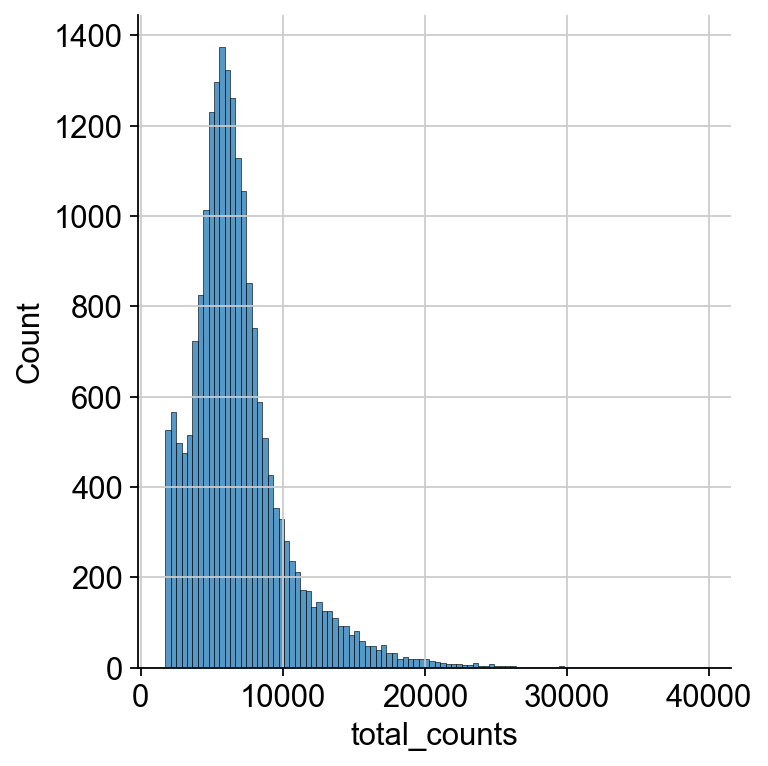

In [14]:
sns.displot(adata.obs["total_counts"], bins=100, kde=False)

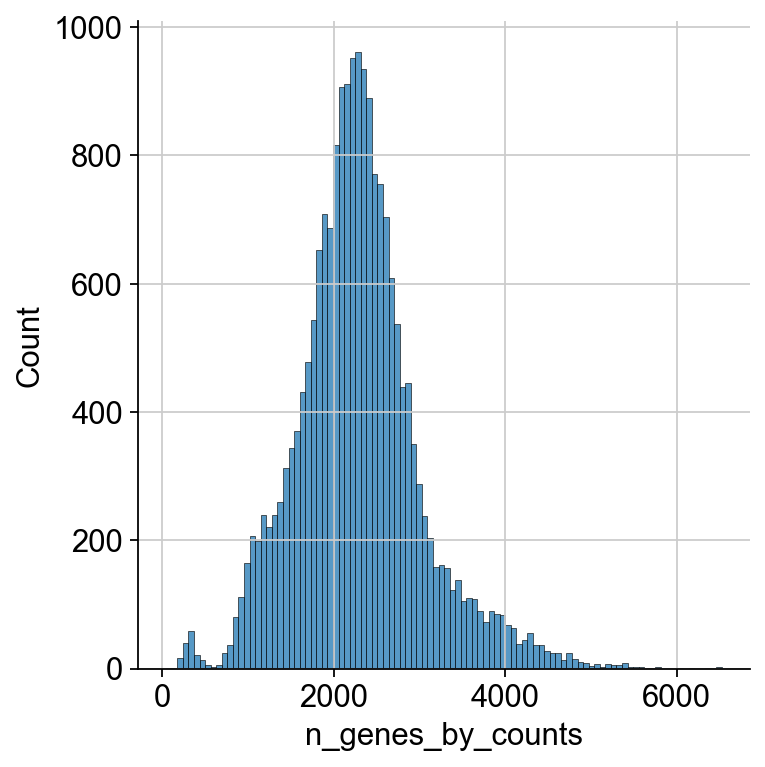

In [15]:
sns.displot(adata.obs["n_genes_by_counts"], bins=100, kde=False)

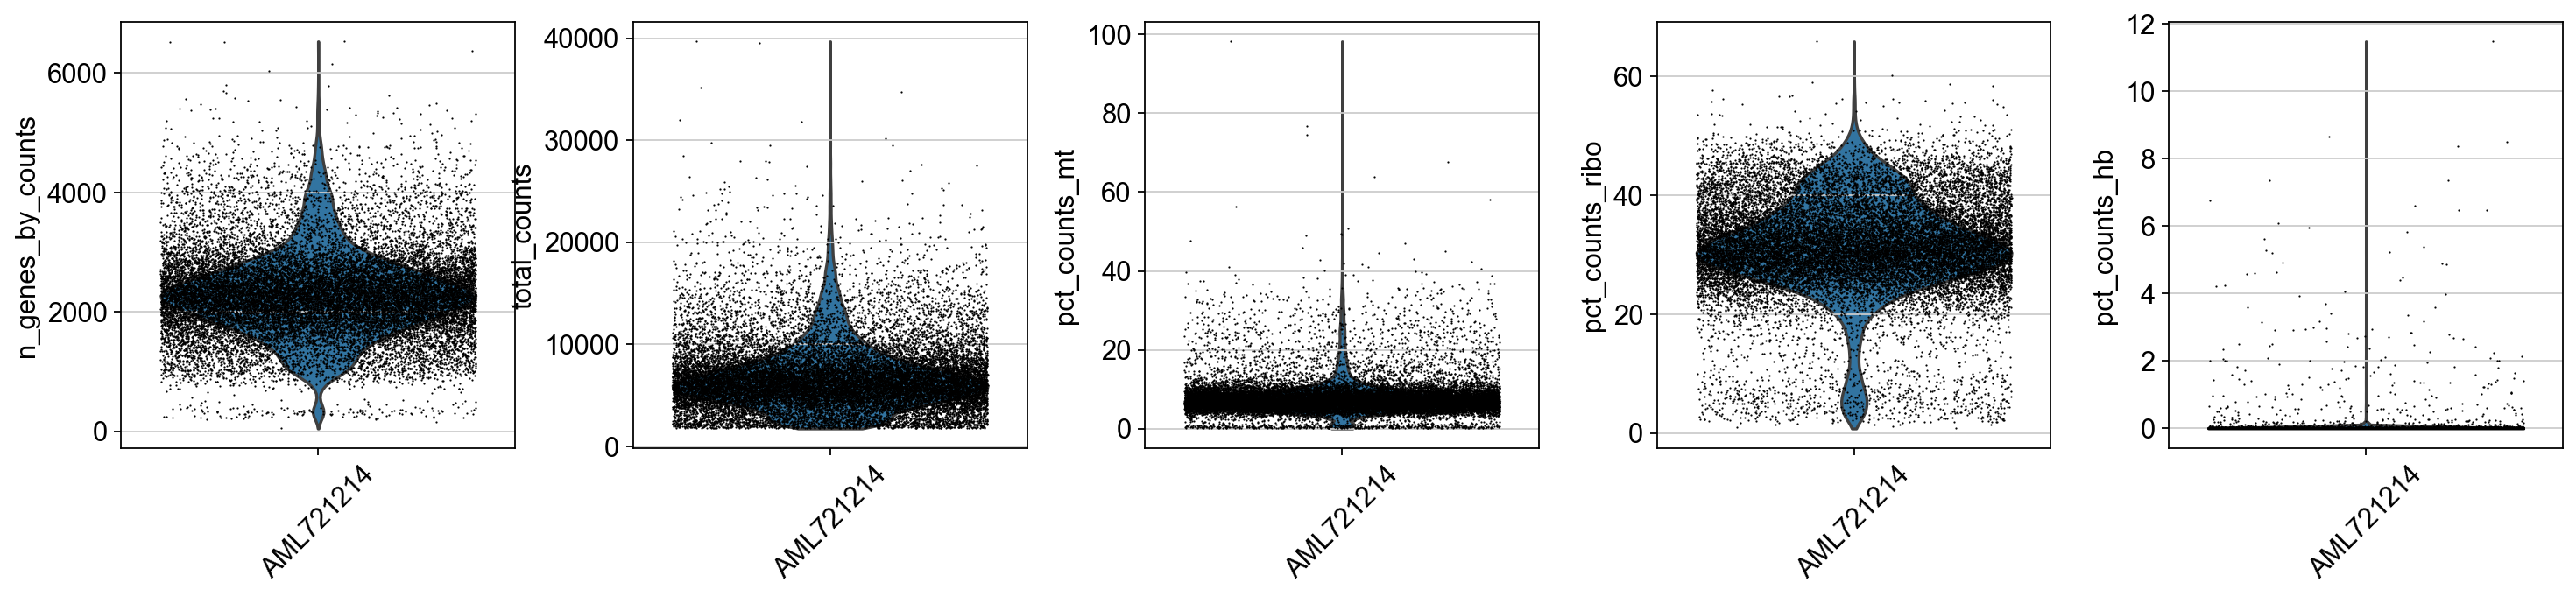

In [16]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

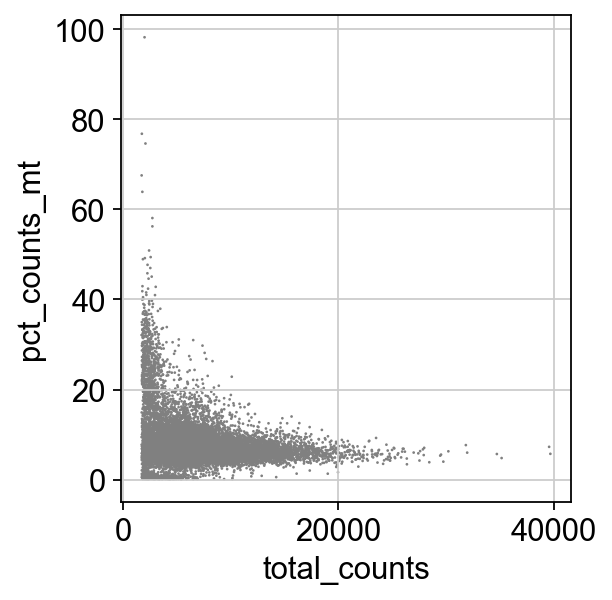

In [17]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

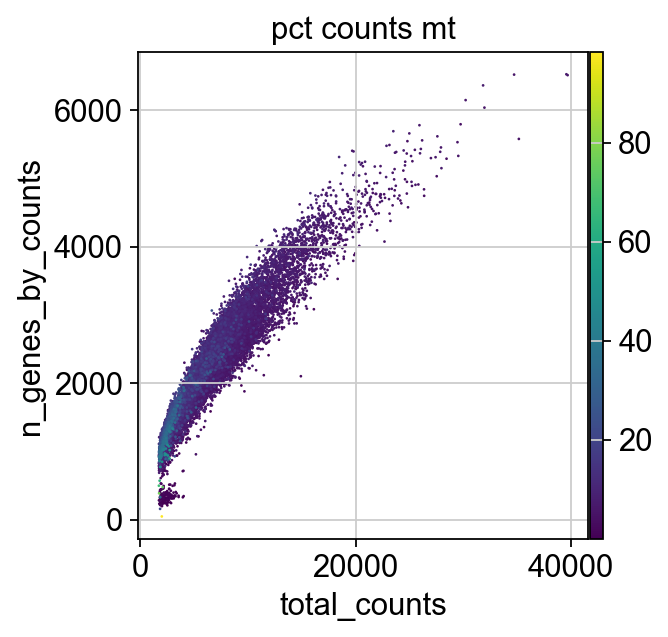

In [18]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

### Cell Filtering

Cell filtering strategy adapted from:
https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

In [19]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (
        np.median(M) + nmads * M.mad() < M)
    print(metric, np.median(M) + nmads * M.mad())
    return outlier

In [20]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5))
adata.obs.outlier.value_counts()

log1p_total_counts 10.539595395326614
log1p_n_genes_by_counts 8.983446787472307
pct_counts_in_top_20_genes 35.856636921666116


/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:3: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  outlier = (M < np.median(M) - nmads * M.mad()) | (
/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:4: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  np.median(M) + nmads * M.mad() < M)
/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  print(metric, np.median(M) + nmads * M.mad())


False    19906
True       315
Name: outlier, dtype: int64

In [21]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    adata.obs["pct_counts_mt"] > 10
)
adata.obs.mt_outlier.value_counts()

pct_counts_mt 15.278050422668457


/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:3: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  outlier = (M < np.median(M) - nmads * M.mad()) | (
/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:4: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  np.median(M) + nmads * M.mad() < M)
/var/folders/32/8mghz1t14416wmmns0p1mgx80000gr/T/ipykernel_7816/3224347244.py:5: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  print(metric, np.median(M) + nmads * M.mad())


False    17214
True      3007
Name: mt_outlier, dtype: int64

In [22]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 20221
Number of cells after filtering of low quality cells: 17046


#### Post-Filtering QC Plots

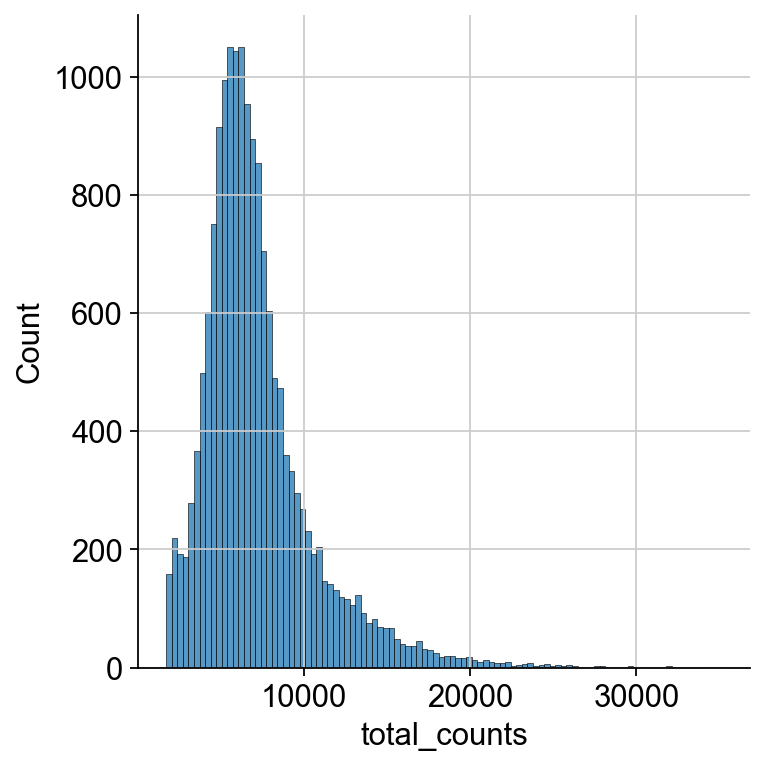

In [23]:
sns.displot(adata.obs["total_counts"], bins=100, kde=False)

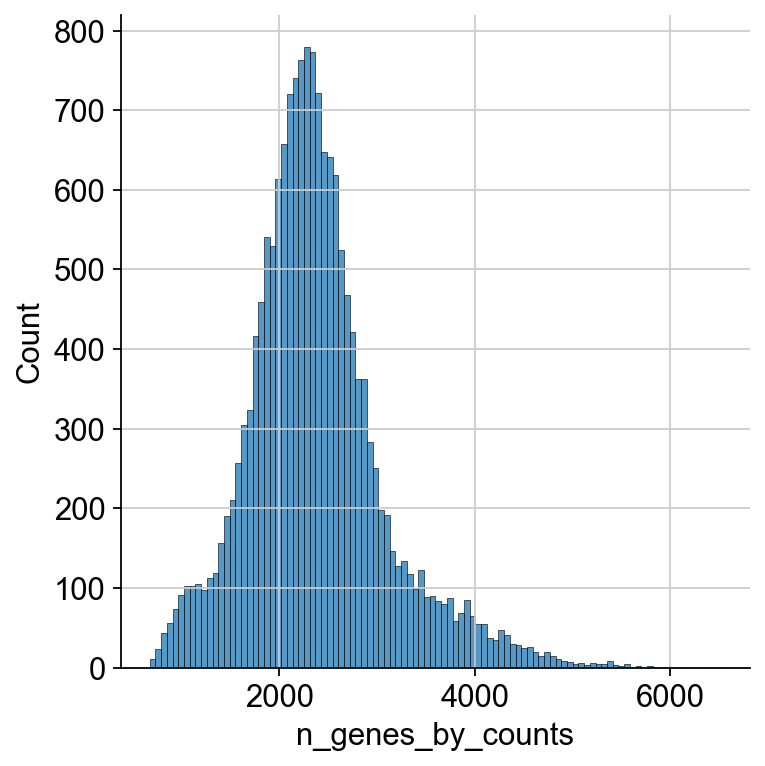

In [24]:
sns.displot(adata.obs["n_genes_by_counts"], bins=100, kde=False)

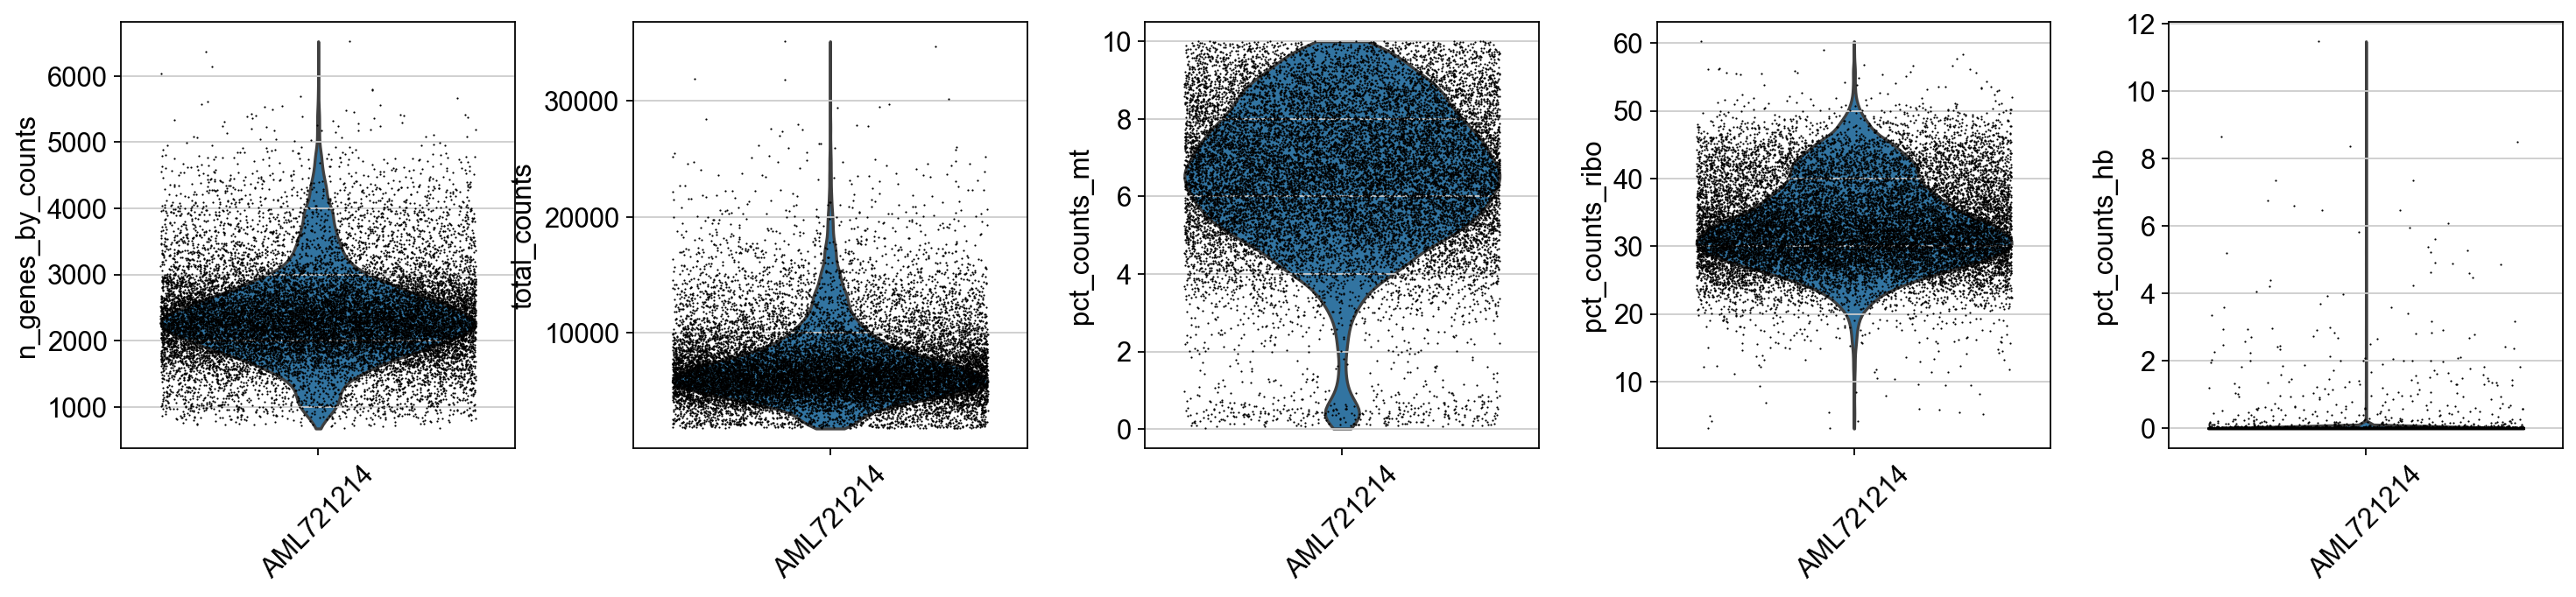

In [25]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample', rotation= 45)

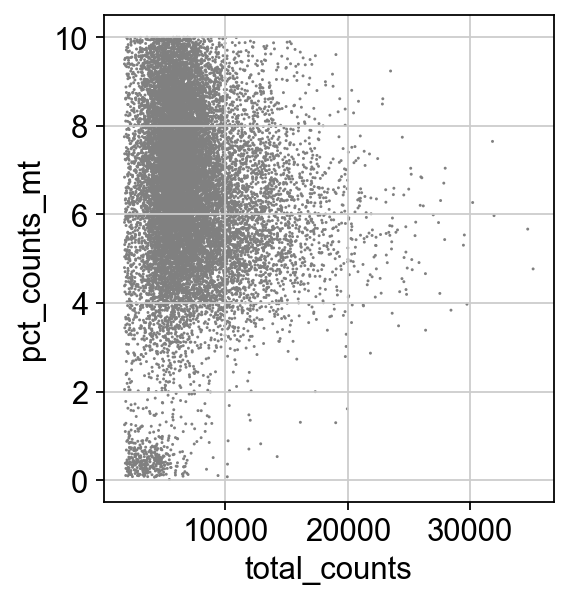

In [26]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

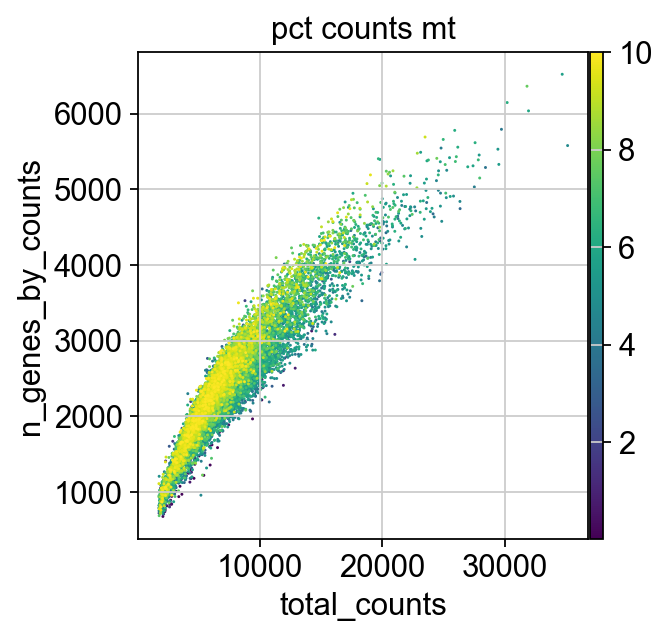

In [27]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')

### Save AnnData

In [28]:
# Save high quality cells with all genes - for integration
adata.layers["counts"] = adata.X.copy()
adata.write_h5ad(cells_file)

### Gene Filtering

Filtering of abundant artefactual genes, and genes expressed in very few cells. 

normalizing counts per cell
    finished (0:00:00)


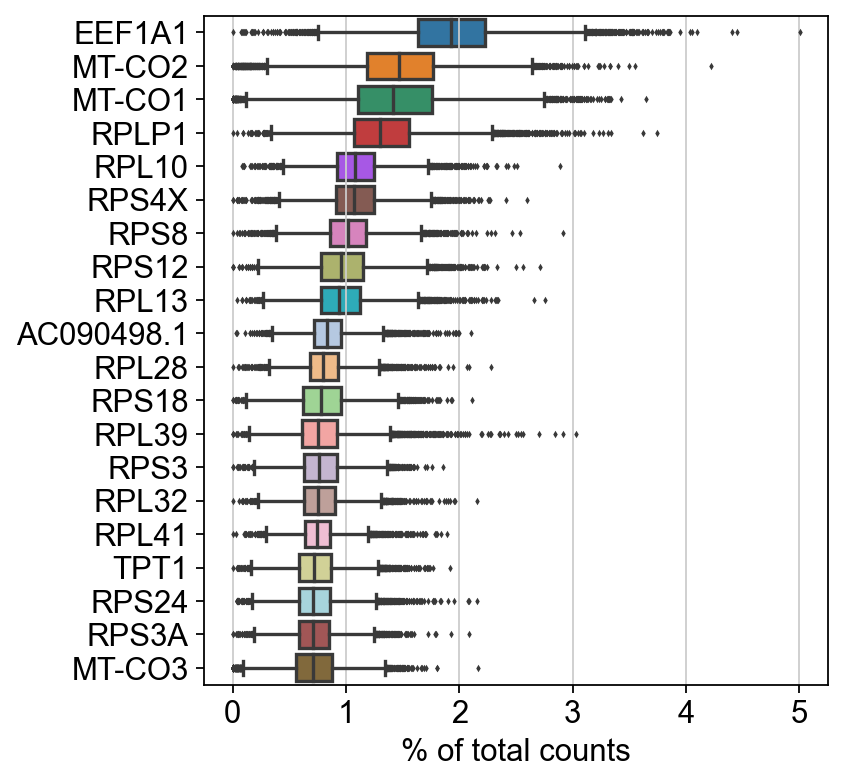

In [29]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [30]:
# Perform Gene Filtering
sc.pp.filter_genes(adata, min_cells=3)
print(adata.n_obs, adata.n_vars)

# MALAT1 filtering is often required
#malat1 = adata.var_names.str.startswith('MALAT1')
#keep = np.invert(malat1)
#adata = adata[:,keep]

filtered out 13438 genes that are detected in less than 3 cells
17046 20256


normalizing counts per cell
    finished (0:00:00)


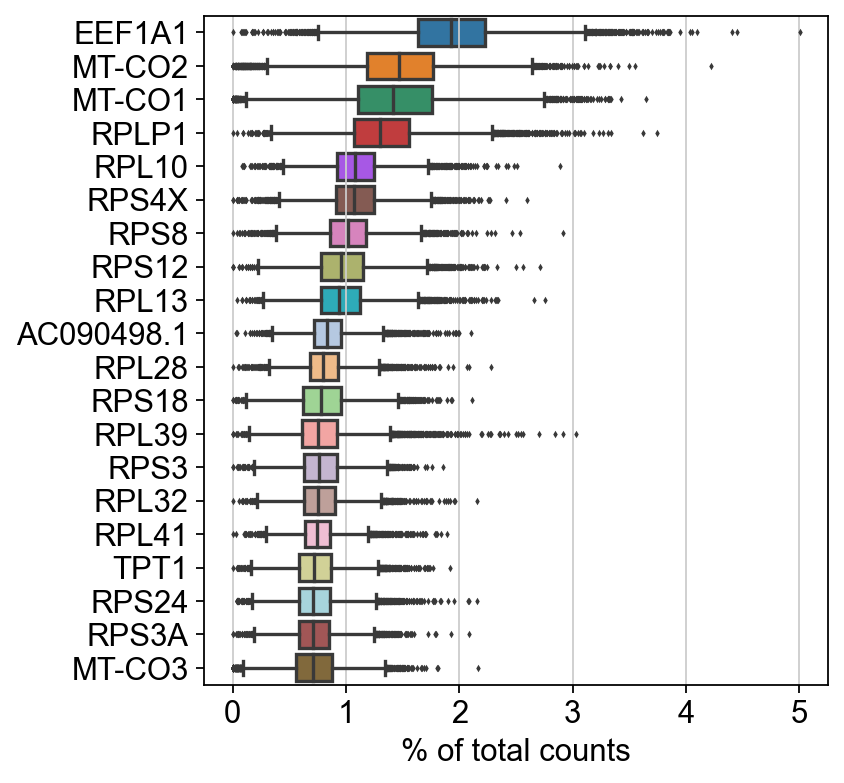

17046 20256


In [31]:
# Visualise Abundant Genes Post-Filtering
sc.pl.highest_expr_genes(adata, n_top=20)
print(adata.n_obs, adata.n_vars)

### Annotate Patient Sex

Can be useful to identify causes of bias further downstream. 

In [32]:
# Using biomart to identify relevant genes
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [33]:
# Find percentage chrY
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])

adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis=1) / np.sum(adata.X, axis=1) * 100

In [34]:
# Count XIST per cell
adata.obs["XIST-counts"] = adata.X[:,adata.var_names.str.match('XIST')].toarray()

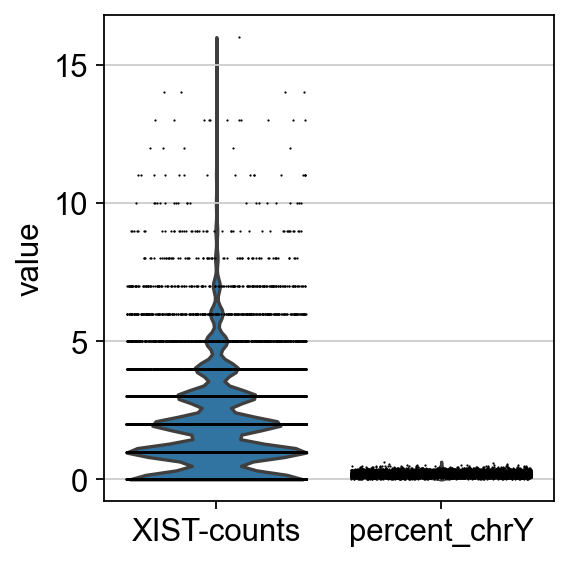

In [35]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter=0.4)

## Pre-Processing Steps Complete!

Consolidate the original raw count matrix in 'adata.layers' and save cell/gene filtered andata.

We will only use the cell filtered version for integration.

In [36]:
adata.layers["counts"] = adata.X.copy()
adata.write_h5ad(results_file)

### Reproducibility: Environment Configuration

In [37]:
!conda list

# packages in environment at /Users/jwhittle/opt/anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39hca03da5_1  
absl-py                   1.4.0                    pypi_0    pypi
adjusttext                1.2.0                    pypi_0    pypi
aiohttp                   3.8.4                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2022.10                  py39_0  
anaconda-client           1.11.0           py39hca03da5_0  
anaconda-navigator        2.3.1            py39hca03da5_0  
anaconda-project          0.11.1           py39hca03da5_0  
anndata                   0.8.0                    pypi_0    pypi
annoy                     1.17.1                   pypi_0    pypi
anyio                     3.5.0            py39hca03da5_0  
appdirs                   1.4.4              pyhd3eb1b0